In [6]:
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS
import torch 

bundle = HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device=device)
sample_rate = bundle.sample_rate
print(f'Sample rate: {sample_rate}')

Sample rate: 44100


In [7]:
from torchaudio.utils import download_asset
import torchaudio

SAMPLE_SONG = download_asset('tutorial-assets/hdemucs_mix.wav')
waveform, sample_rate = torchaudio.load(SAMPLE_SONG)

waveform.shape, sample_rate

(torch.Size([2, 7560512]), 44100)

In [8]:
waveform = waveform.to(device)
mixture = waveform

ref = waveform.mean(0)
waveform = (waveform - ref.mean()) / ref.std()
ref.shape

torch.Size([7560512])

In [9]:
from lib.toolkits import separate_sources

print("Separating track")
sources = separate_sources(
    model=model, mix=waveform[None], device=device, segment=10, overlap=0.1, sample_rate=sample_rate
)[0]
sources = sources * ref.std() + ref.mean()

sources_list = model.sources
sources = list(sources)
audios = dict(zip(sources_list, sources))
audios.keys()

Separating track


dict_keys(['drums', 'bass', 'other', 'vocals'])

In [10]:
N_FFT = 4096
N_HOP = 4
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)

segment_start = 150
segment_end = 155

frame_start = segment_start * sample_rate
frame_end = segment_end * sample_rate

drums_original = download_asset("tutorial-assets/hdemucs_drums_segment.wav")
bass_original = download_asset("tutorial-assets/hdemucs_bass_segment.wav")
vocals_original = download_asset("tutorial-assets/hdemucs_vocals_segment.wav")
other_original = download_asset("tutorial-assets/hdemucs_other_segment.wav")

drums_spec = audios["drums"][:, frame_start:frame_end].cpu()
drums, sample_rate = torchaudio.load(drums_original)

bass_spec = audios["bass"][:, frame_start:frame_end].cpu()
bass, sample_rate = torchaudio.load(bass_original)

vocals_spec = audios["vocals"][:, frame_start:frame_end].cpu()
vocals, sample_rate = torchaudio.load(vocals_original)

other_spec = audios["other"][:, frame_start:frame_end].cpu()
other, sample_rate = torchaudio.load(other_original)

mix_spec = mixture[:, frame_start:frame_end].cpu()

# Mixture Clip

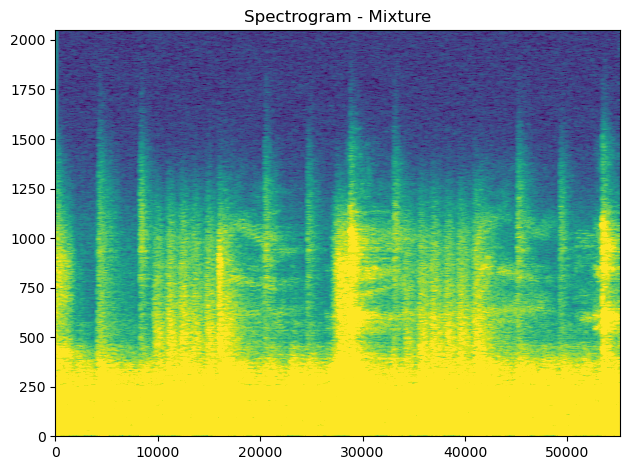

In [12]:
from IPython.display import Audio
from lib.toolkits import plot_spectrogram

plot_spectrogram(stft(mix_spec)[0], "Spectrogram - Mixture")
Audio(mix_spec, rate=sample_rate)

# Vocals Audio

SDR score is:  8.79235925815964


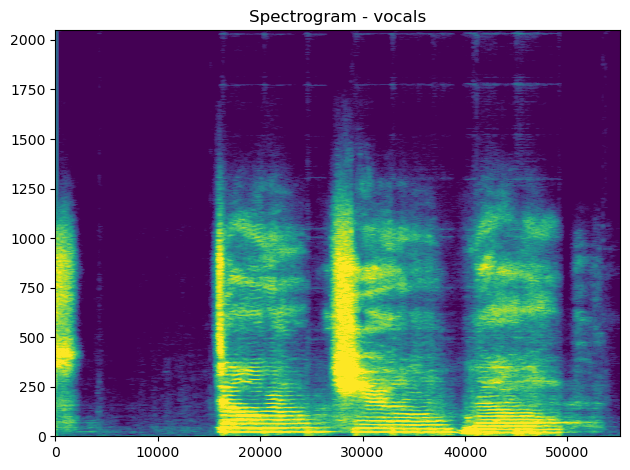

In [14]:
from lib.toolkits import output_results

output_results(vocals, vocals_spec, "vocals", tsf=stft)
Audio(vocals_spec, rate=sample_rate)